This notebook walks through some ways to explore the [Enterprise Human Resources Integration-Statistical Data Mart](https://www.fedscope.opm.gov/datadefn/aehri_sdm.asp) (EHRI-SDM) data cube. It assumes one of the data cube `zip` files [available from OPM](https://www.opm.gov/data/datasets/) has been extracted to a `data` folder in the current working directory. For example, the [March 2023 cube](https://www.opm.gov/data/datasets/Files/685/875df97f-0f3f-4a7c-b6b1-2a3b0d85c375.zip) or the [December 2022 cube](https://www.opm.gov/data/datasets/Files/679/4e9c7654-2623-4521-9975-d5ecec8b968e.zip). These zip files also include a data dictionary, but a more detailed description can be found under [Data Definitions](https://www.fedscope.opm.gov/datadefn/index.asp). It is necessary to understand the data dictionary to more easily drill down into the cube. For instance, `LOC` refers to the official duty station of an employee with:
* 11 = Washington D.C.
* 24 = Maryland
* 51 = Virginia

which you can see in `DTloc.TXT`. Next, `AGELVL` refers to an individual's age range:
* A = Less than 20
* B = 20-24
* C = 25-29
* D = 30-34
* E = 35-39
* F = 40-44
* G = 45-49
* H = 50-54
* I = 55-59
* J = 60-64
* K = 65 or more

`EDLVL` refers to an individual's education level, with the most common being:
* 13 = BACHELOR'S DEGREE
* 17 = MASTER'S DEGREE
* 21 = DOCTORATE DEGREE
* 22 = POST-DOCTORATE

`AGYSUB` refers to the employing agency, for example:
* FD00 = FDIC
* HE39 = CDC
* SE00 = SEC
* FRFT = CFPB
* TRAJ = OCC
* CU00 = NCUA
* HFHA = FHFA
* TR91 = Treasury (Departmental)


# Imports and Configuration

In [ ]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from matplotlib import font_manager
font_path = '/data/SourceSansPro-Regular.otf'  # Update this to your actual file path
prop = font_manager.FontProperties(fname=font_path)

from matplotlib.colors import to_rgb, to_rgba

# Helper Functions

In [ ]:
# preprocesses datacube
def preprocessDatacube(datacube):

    # drop NA in salary, OCC column
    datacube.dropna(subset=['OCC','SALARY'], inplace=True)
    datacube.dropna(subset=['OCC','SALARY'], inplace=True)

    # convert OCC and STEMOCC to strings
    datacube['OCC']     = datacube['OCC'].astype(str)
    datacube['STEMOCC'] = datacube['STEMOCC'].astype(str)
    datacube['OCC']     = datacube['OCC'].astype(str)
    datacube['STEMOCC'] = datacube['STEMOCC'].astype(str)

    # zero pad occ and stem occ to 4 digit with leading zeroes
    datacube['OCC']     = datacube['OCC'].apply(lambda x: x.zfill(4))
    datacube['STEMOCC'] = datacube['STEMOCC'].apply(lambda x: x.zfill(4))
    datacube['OCC']     = datacube['OCC'].apply(lambda x: x.zfill(4))
    datacube['STEMOCC'] = datacube['STEMOCC'].apply(lambda x: x.zfill(4))

    # drop **** OCC
    datacube = datacube[datacube['OCC'] != '****']
    datacube = datacube[datacube['OCC'] != '****']

    # EDLVL must be a string without decimal
    datacube['EDLVL'] = datacube['EDLVL'].astype(str)
    datacube['EDLVL'] = datacube['EDLVL'].apply(lambda x: x.split('.')[0])
    datacube['EDLVL'] = datacube['EDLVL'].astype(str)
    datacube['EDLVL'] = datacube['EDLVL'].apply(lambda x: x.split('.')[0])

    # occupational series mapping
    occupationalAttributes_df         = pd.read_csv('/Workspace/Users/jrohal@fdic.gov/data/ehri-sdm/DTocc.txt')                                # read in attributes
    occupationalAttributes_df['OCCT'] = occupationalAttributes_df['OCCT'].apply(lambda x: x.split('-')[1].title())                             # split the series off
    seriesMapping                     = pd.Series(occupationalAttributes_df['OCCT'].values, index=occupationalAttributes_df['OCC']).to_dict()  # build mapping

    # agency mapping
    agencyAttributes_df            = pd.read_csv('/Workspace/Users/jrohal@fdic.gov/data/ehri-sdm/DTagy.txt')                                   # read in attributes
    agencyAttributes_df['AGYSUBT'] = agencyAttributes_df['AGYSUBT'].apply(lambda x: x.split('-')[1].title())                                   # split the agency off
    agencyMapping                  = pd.Series(agencyAttributes_df['AGYSUBT'].values, index=agencyAttributes_df['AGYSUB']).to_dict()           # build mapping

    # age mapping
    ageAttributes_df = pd.read_csv('/Workspace/Users/jrohal@fdic.gov/data/ehri-sdm/DTagelvl.txt')                               # read in attributes
    ageMapping       = pd.Series(ageAttributes_df['AGELVLT'].values, index=ageAttributes_df['AGELVL']).to_dict()                # build mapping

    # location mapping
    locAttributes_df         = pd.read_csv('/Workspace/Users/jrohal@fdic.gov/data/ehri-sdm/DTloc.txt')                          # read in attributes
    locAttributes_df['LOCT'] = locAttributes_df['LOCT'].apply(lambda x: x.split('-')[1].title())                                # split the location off
    locMapping               = pd.Series(locAttributes_df['LOCT'].values, index=locAttributes_df['LOC']).to_dict()              # build mapping

    # education mapping
    edAttributes_df           = pd.read_csv('/Workspace/Users/jrohal@fdic.gov/data/ehri-sdm/DTedlvl.txt')                            # read in attributes
    edAttributes_df.dropna(subset=['EDLVL'], inplace=True)                                                                           # drop nan edlvl
    edAttributes_df['EDLVL']  = edAttributes_df['EDLVL'].apply(lambda x: re.sub(r'^0+(?!$)', '', x))                                 # strip leading 0 from numbers
    edAttributes_df['EDLVLT'] = edAttributes_df['EDLVLT'].apply(lambda x: x[3:].title())                                             # split the education off
    edMapping                 = pd.Series(edAttributes_df['EDLVLT'].values, index=edAttributes_df['EDLVL']).to_dict()                # build mapping

    # los mapping
    losAttributes_df           = pd.read_csv('/Workspace/Users/jrohal@fdic.gov/data/ehri-sdm/DTloslvl.txt')                            # read in attributes
    losMapping                 = pd.Series(losAttributes_df['LOSLVLT'].values, index=losAttributes_df['LOSLVL']).to_dict()             # build mapping

    # add agency, occupation, age, location, edlvl columns for easier reading
    datacube['Agency']             = datacube['AGYSUB'].map(agencyMapping)
    datacube['Occupation']         = datacube['OCC'].map(seriesMapping)
    datacube['Age']                = datacube['AGELVL'].map(ageMapping)
    datacube['Location']           = datacube['LOC'].map(locMapping)
    datacube['Education']          = datacube['EDLVL'].map(edMapping)
    datacube['Length of Service']  = datacube['LOSLVL'].map(losMapping)

    # return
    return datacube

In [ ]:
# the following function selects a subset of the datacube according to the given filters
# series = regular expression to match OCCupational series
# age, agency, location, education, lengthservice, payplan all follow the definitions from the respective data dictionaries: AGYSUB, LOC, EDLVL, LOSLVL, PPGRD
def OPM_df(df, series, age=None, agency=None, location=None, education=None, lengthservice=None, payplan=None, limit=None, debug=False):   
    # use age if given
    if age:
        ageFlag = df['AGELVL'].isin(age)
    else:
        ageFlag = True

    # use agency if given
    if agency:
        agencyFlag = df['AGYSUB'].isin(agency)
    else:
        agencyFlag = True
        
    # use location if given
    if location:
        locationFlag =  df['LOC'].isin(location)
    else:
        locationFlag = True
    
    # use education if given
    if education:
        educationFlag = df['EDLVL'].isin(education)
    else:
        educationFlag = True
        
    # use length of service if given
    if lengthservice:
        losFlag = df['LOSLVL'].isin(lengthservice)
    else:
        losFlag = True
        
    # use pay plan if given
    if payplan:
        payplanFlag = df['PPGRD'].isin(payplan)
    else:
        payplanFlag = True
    
    # get the dataframe using the flags
    sub_df = df[df['OCC'].str.contains(series) & ageFlag & agencyFlag & locationFlag & educationFlag & losFlag & payplanFlag]
    
    # print out what you are requesting
    if debug:
        print(f"Series:    {'    '.join(sorted(list(sub_df['Occupation'].unique())))}")
        print(f"Age:       {'    '.join(sorted(list(sub_df['Age'].unique())))}")
        print(f"Location:  {'    '.join(sorted(list(sub_df['Location'].unique())))}")
        print(f"Education: {'    '.join(sorted(list(sub_df['Education'].unique())))}")
        print(f"LOS:       {'    '.join(sorted(list(sub_df['Length of Service'].unique())))}")
        print(f"Payplan:   {'    '.join(sorted(list(sub_df['PPGRD'].unique())))}")
        print(f"Agency:    {'    '.join(list(sub_df['Agency'].unique())).replace('Department Of ', '').replace('The ','')}")
    
    # total number of series in government
    print(f"Total number   = {len(sub_df)}")

    # average salary
    print(f"Average salary = {sub_df['SALARY'].mean()}")
    
    # extra new line
    print()

    # show top highest paid
    if limit:
        return sub_df.sort_values(by='SALARY', ascending=False).head(limit)
    else:
        return sub_df.sort_values(by='SALARY', ascending=False)

# Preprocess the Data Cube

In [ ]:
# read the big datacube
datacube_dec2022 = pd.read_csv('data/ehri-sdm/FACTDATA_DEC2022.TXT')
datacube_mar2023 = pd.read_csv('data/ehri-sdm/FACTDATA_MAR2023.TXT')
datacube_dec2023 = pd.read_csv('data/ehri-sdm/FACTDATA_DEC2023.TXT')
datacube_mar2024 = pd.read_csv('data/ehri-sdm/FACTDATA_MAR2024.TXT')
datacube_jun2024 = pd.read_csv('data/ehri-sdm/FACTDATA_JUN2024.TXT')
datacube_sep2024 = pd.read_csv('data/ehri-sdm/FACTDATA_SEP2024.TXT')

# preprocess it
datacube_dec2022 = preprocessDatacube(datacube_dec2022)
datacube_mar2023 = preprocessDatacube(datacube_mar2023)
datacube_dec2023 = preprocessDatacube(datacube_dec2023)
datacube_mar2024 = preprocessDatacube(datacube_mar2024)
datacube_jun2024 = preprocessDatacube(datacube_jun2024)
datacube_sep2024 = preprocessDatacube(datacube_sep2024)

# Exploration

In [ ]:
# salaries for data scientists at the FDIC in the DMV area
OPM_df(datacube_sep2024,'1560',agency=['FD00'], location=['11','24','51'])

Total number   = 17
Average salary = 175049.58823529413



,AGYSUB,LOC,AGELVL,EDLVL,GSEGRD,LOSLVL,OCC,PATCO,PP,PPGRD,SALLVL,STEMOCC,SUPERVIS,TOA,WORKSCH,WORKSTAT,DATECODE,EMPLOYMENT,SALARY,LOS,Agency,Occupation,Age,Location,Education,Length of Service
887976,FD00,11,G,17,15.0,E,1560,1,99,CG-15,22,1560,8,10,F,1,202409,1,245965.0,12.2,Federal Deposit Insurance Corporation,Data Science Series,45-49,District Of Columbia,Master'S Degree,10 - 14 years
886525,FD00,11,J,17,15.0,D,1560,1,99,CG-15,22,1560,8,10,F,1,202409,1,240103.0,5.8,Federal Deposit Insurance Corporation,Data Science Series,60-64,District Of Columbia,Master'S Degree,5 - 9 years
887065,FD00,11,I,17,14.0,B,1560,1,99,CG-14,21,1560,8,15,F,1,202409,1,222793.0,1.8,Federal Deposit Insurance Corporation,Data Science Series,55-59,District Of Columbia,Master'S Degree,1 - 2 years
887562,FD00,11,D,21,15.0,D,1560,1,99,CG-15,19,1560,8,10,F,1,202409,1,191946.0,6.3,Federal Deposit Insurance Corporation,Data Science Series,30-34,District Of Columbia,Doctorate Degree,5 - 9 years
885694,FD00,11,G,21,15.0,E,1560,1,99,CG-15,18,1560,8,10,F,1,202409,1,185499.0,13.7,Federal Deposit Insurance Corporation,Data Science Series,45-49,District Of Columbia,Doctorate Degree,10 - 14 years
886256,FD00,11,E,17,15.0,D,1560,1,99,CG-15,18,1560,8,10,F,1,202409,1,182289.0,8.8,Federal Deposit Insurance Corporation,Data Science Series,35-39,District Of Columbia,Master'S Degree,5 - 9 years
889495,FD00,11,E,17,15.0,D,1560,1,99,CG-15,18,1560,8,10,F,1,202409,1,182289.0,9.9,Federal Deposit Insurance Corporation,Data Science Series,35-39,District Of Columbia,Master'S Degree,5 - 9 years
888923,FD00,11,I,21,13.0,F,1560,1,99,CG-13,18,1560,8,10,F,1,202409,1,180063.0,18.3,Federal Deposit Insurance Corporation,Data Science Series,55-59,District Of Columbia,Doctorate Degree,15 - 19 years
887545,FD00,11,E,21,14.0,D,1560,1,99,CG-14,17,1560,8,10,F,1,202409,1,178387.0,9.8,Federal Deposit Insurance Corporation,Data Science Series,35-39,District Of Columbia,Doctorate Degree,5 - 9 years
887606,FD00,11,G,17,14.0,F,1560,1,99,CG-14,17,1560,8,10,F,1,202409,1,173433.0,15.3,Federal Deposit Insurance Corporation,Data Science Series,45-49,District Of Columbia,Master'S Degree,15 - 19 years


/home/spark-f1fe5661-3edf-469d-b568-ec/.ipykernel/205859/command-2301581426400848-760772483:42: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sub_df = df[df['OCC'].str.contains(series) & ageFlag & agencyFlag & locationFlag & educationFlag & losFlag & payplanFlag]


Total number   = 2096
Average salary = 194660.46946564884



/home/spark-f1fe5661-3edf-469d-b568-ec/.ipykernel/205859/command-2301581426400850-756991250:61: FutureWarning: The default value of regex will change from True to False in a future version.
  DTocc['OCCT'] = DTocc['OCCT'].str.replace(r'^[0-9]{4}-', '').str.title()


Five-Number Summary for each OCC Group:
           min        25%       50%        75%       max
OCC                                                     
0018  178160.0  193400.00  208640.0  223880.00  239120.0
0080   96597.0  151831.50  178972.5  212867.50  275000.0
0089  145149.0  157963.00  187739.0  225875.00  250360.0
0110   61586.0  110025.25  216214.0  243800.75  275000.0
0132  171959.0  194492.00  202360.0  219019.50  267927.0
0180  129904.0  220991.00  220991.0  229487.00  234163.0
0199   44436.0   44436.00   61586.0   68458.00   76050.0
0201   68752.0  145075.00  172568.0  215069.50  275000.0
0203   74886.0   86512.50   96691.5  105053.50  111229.0
0260  133555.0  179164.00  190739.0  195975.00  225623.0
0301   61586.0  157951.00  196585.0  244370.00  275000.0
0303   67647.0   87231.00  100443.0  111229.00  122856.0
0305   81079.0   81079.00   81079.0   81079.00   81079.0
0306  129904.0  137335.50  154340.0  184123.75  267927.0
0308  129904.0  146534.00  163534.0  178160.00  

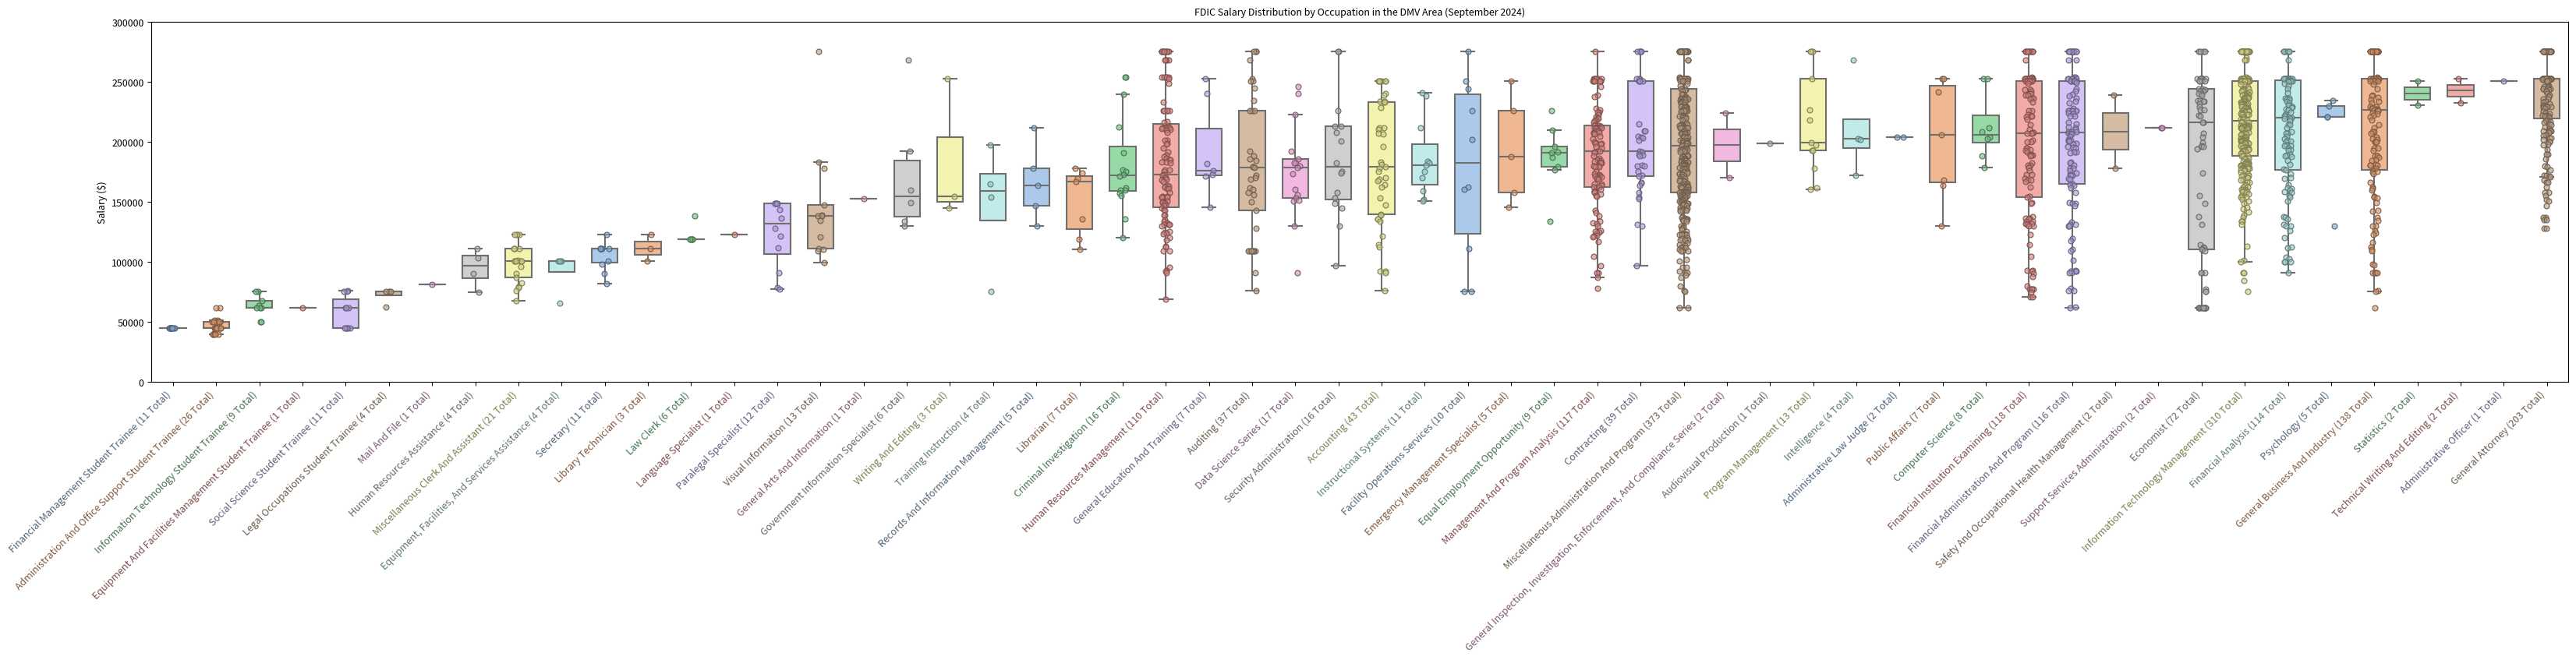

In [ ]:
# take a subset of the datacube
filtered_data = OPM_df(datacube_sep2024,'(^0|^1|^2|^3|^4|^5|^6|^7|^8|^9)',agency=['FD00'], location=['11','24','51'])

# size of each OCC series and median for each OCC series in two different columns
grouped_df = filtered_data.groupby('OCC')['SALARY'].agg([np.median, 'size'])

# Rename columns for clarity
grouped_df.columns = ['Median', 'Size']

# Sort by 'Median' in ascending order
sorted_df = grouped_df.sort_values(by='Median')

# Update OCC category based on sorted median values
sorted_occ_order = sorted_df.index

# create the axes and widen the plot
fig, ax = plt.subplots(figsize=(40, 6))

# Define the color palette
palette = sns.color_palette('pastel', len(sorted_occ_order))

# Function to darken a color
def darken_color(color, amount=0.5):
    return tuple(max(0, min(1, c * amount)) for c in color[:3])

# Create sorted dot plot with darker and transparent colors
for i, color in enumerate(palette):
    dark_color = darken_color(to_rgb(color), 0.8)
    # do a strip plot
    sns.stripplot(x='OCC', y='SALARY', data=filtered_data[filtered_data['OCC'] == sorted_occ_order[i]], ax=ax,
                  order=[sorted_occ_order[i]], color=to_rgba(dark_color, 0.6),
                  edgecolor=darken_color(to_rgb(color), 0.5), linewidth=0.8)
    # do a bee swarm plot
    # sns.swarmplot(x='OCC', y='SALARY', data=filtered_data[filtered_data['OCC'] == sorted_occ_order[i]], ax=ax, 
    #               order=[sorted_occ_order[i]], color=to_rgba(dark_color, 0.6), 
    #               edgecolor=darken_color(to_rgb(color), 0.5), linewidth=0.8, size=2)
    

# Group by OCC and create the box plot
sns.boxplot(x='OCC', y='SALARY', data=filtered_data, ax=ax,  order=sorted_occ_order, showmeans=False, palette=palette, width=0.6, showfliers=False)

# Set titles and labels with the desired font
ax.set_title('FDIC Salary Distribution by Occupation in the DMV Area (September 2024)', fontproperties=prop)
ax.set_xlabel(None)
ax.set_ylabel('Salary ($)', fontproperties=prop)

# set max and min on y-axis limits
ax.set_ylim(0, 300000)

# Remove the automatic 'by' title to clean up the plot
plt.suptitle('')

# Apply custom font to x-ticks and y-ticks
for label in ax.get_xticklabels():
    label.set_fontproperties(prop)

# load the DTocc file and read in only the OCC and OCCT columns
DTocc = pd.read_csv('/Workspace/Users/jrohal@fdic.gov/data/ehri-sdm/DTocc.txt', usecols=['OCC', 'OCCT'], index_col='OCC')

# remove the four digits and the slash from the front of the OCCT column and then correct the case
DTocc['OCCT'] = DTocc['OCCT'].str.replace(r'^[0-9]{4}-', '').str.title()

# merge the sorted_df with DTocc on the OCC column
merged_df = sorted_df.merge(DTocc, left_index=True, right_index=True)

# create a list of strings of OCCT values and (Size) from merged_df
xlabels = [f'{row[0]} ({row[1]} Total)' for row in merged_df[['OCCT', 'Size']].values]

# set x-axis labels based on occupational series
ax.set_xticklabels(xlabels, rotation=45, ha='right', fontproperties=prop)

# color the x-axis labels the same as the edgecolor from the stripplot
for i, color in enumerate(palette):
    ax.get_xticklabels()[i].set_color(darken_color(to_rgb(color), 0.5))

# set font for ylabels
for label in ax.get_yticklabels():
    label.set_fontproperties(prop)

# output five number statistics for each group
summary_stats = filtered_data.groupby('OCC')['SALARY'].describe(percentiles=[.25, .5, .75])
five_number_summary = summary_stats.loc[:, ['min', '25%', '50%', '75%', 'max']]

print("Five-Number Summary for each OCC Group:")
print(five_number_summary)
print("\n")

/home/spark-f1fe5661-3edf-469d-b568-ec/.ipykernel/205859/command-2301581426400848-760772483:42: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sub_df = df[df['OCC'].str.contains(series) & ageFlag & agencyFlag & locationFlag & educationFlag & losFlag & payplanFlag]


Total number   = 907
Average salary = 189123.8732083793



/home/spark-f1fe5661-3edf-469d-b568-ec/.ipykernel/205859/command-5469035457914396-402911713:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{int(tick)}' for tick in ax.get_xticks()], fontproperties=prop)
/home/spark-f1fe5661-3edf-469d-b568-ec/.ipykernel/205859/command-5469035457914396-402911713:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(tick)}' for tick in ax.get_yticks()], fontproperties=prop)


Total in cluster   = 22
Average in cluster = 172721.36363636365


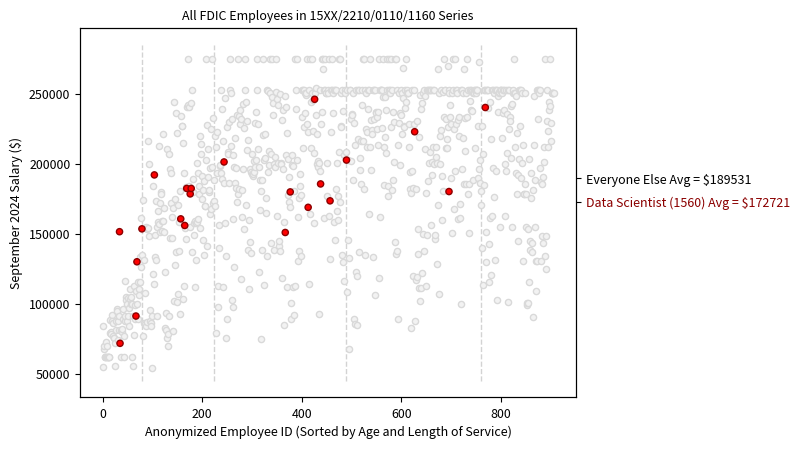

In [ ]:
data = OPM_df(datacube_sep2024,'(^15|2210|0110|1160)', agency=['FD00'])
# sort by length of age and length of service
data.sort_values(by=['AGELVL','LOS'], inplace=True)
# reset the index to match the sort by dropping the old index
data.reset_index(drop=True, inplace=True)
# add an "index" column
data.reset_index(inplace=True)

# colors and edgecolors according to series
colors     = {'1560':'red'}
edgecolors = {'1560':'darkred'}

# create axes
fig, ax = plt.subplots()

# what to show
showFlag = data['OCC'].isin(['1560'])

# scatter plot of salaries 
data[~showFlag].plot.scatter(x='index', y='SALARY', ax=ax, c='0.95', edgecolor='0.85')
data[showFlag].plot.scatter(x='index', y='SALARY', ax=ax, c=data[showFlag]['OCC'].map(colors), edgecolor=data[showFlag]['OCC'].map(edgecolors))

# age splits
# 0-78
# 79-223
# 224-488
# 489-760
# 760-906
# vertical dashed lines for ages at 78.5, 223.5, 488.5, 760.5
ax.vlines([78.5, 223.5, 488.5, 760.5], 45000, 285000, linestyles='dashed', linewidth=1, color='lightgray', zorder=-5)

# compute averages over all data scientists
ds_avg = data[showFlag]['SALARY'].mean()
notds_avg = data[~showFlag]['SALARY'].mean()

# create a second y-axis and copy the y limits from the left axis
y2 = ax.twinx()
y2.set_ylim(ax.get_ylim())
# set the right y-tick labels
y2.set_yticks([ds_avg,notds_avg])
# Set the right y-tick labels
y2.set_yticklabels([f"Data Scientist (1560) Avg = ${int(ds_avg)}",f"Everyone Else Avg = ${int(notds_avg)}"], fontproperties=prop)
# set the colors
plt.setp(y2.get_yticklabels()[0], color='darkred')
plt.setp(y2.get_yticklabels()[1], color='black')

# labels
ax.set_xlabel('Anonymized Employee ID (Sorted by Age and Length of Service)', fontproperties=prop)
ax.set_ylabel('September 2024 Salary ($)', fontproperties=prop)
ax.set_title('All FDIC Employees in 15XX/2210/0110/1160 Series', fontproperties=prop);

# Apply the font to tick labels
ax.set_xticklabels([f'{int(tick)}' for tick in ax.get_xticks()], fontproperties=prop)
ax.set_yticklabels([f'{int(tick)}' for tick in ax.get_yticks()], fontproperties=prop)

# show total in cluster
print(f"Total in cluster   = {len(data[showFlag])}")
print(f"Average in cluster = {data[showFlag]['SALARY'].mean()}")